In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/tesis3/mela_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

In [ ]:
WIDTH = 512
HEIGHT = 512

In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "mask", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)

#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [ ]:

root_dir = '/content/mela_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 900
Number of validation examples: 379


In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:

encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0, 255])

In [ ]:
mask = encoded_inputs["labels"].numpy()

In [ ]:
import matplotlib.pyplot as plt

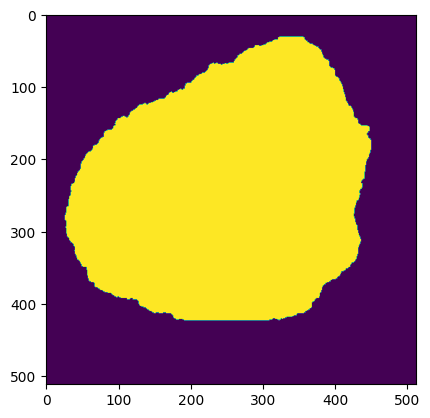

In [ ]:
plt.imshow(mask)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([4, 512, 512])

In [ ]:
#classes = pd.read_csv('class_dict_seg.csv')['name']
id2label = {"0":"background","1":"object"}
label2id = {v: k for k, v in id2label.items()}

we can change model to others pretrained models, for examples MiT-b01,MiT-b02,..., hasta MiTb05 que es el modelo más pesado de segformer.

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.classifier.weight', 'decode_head.linear_

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [ ]:
for epoch in range(1, 101):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model,'/content/drive/MyDrive/tesis3/model_seg_b5_50epoch.pt')

In [ ]:
torch.save(model,'/content/model_seg_b0.pt')

##Inference

In [ ]:
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
d={'name':["background","object"],'r':[0,255],'g':[0,255],'b':[0,255]}
p=pd.DataFrame(data=d)
p

,name,r,g,b
0,background,0,0,0
1,object,255,255,255


In [ ]:
palette=p[['r','g','b']].values

In [ ]:
#df = p
classes = p['name']
#palette = p[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = 'mela_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model=torch.load('/content/model_seg_b0.pt')
#model=torch.load('/content/drive/MyDrive/tesis3/model_seg_b5_50epoch.pt')
model=torch.load('/content/drive/MyDrive/tesis3/model_seg_b5.pt')
#model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         #num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         #reshape_last_stage=True)
model = model.to(device)

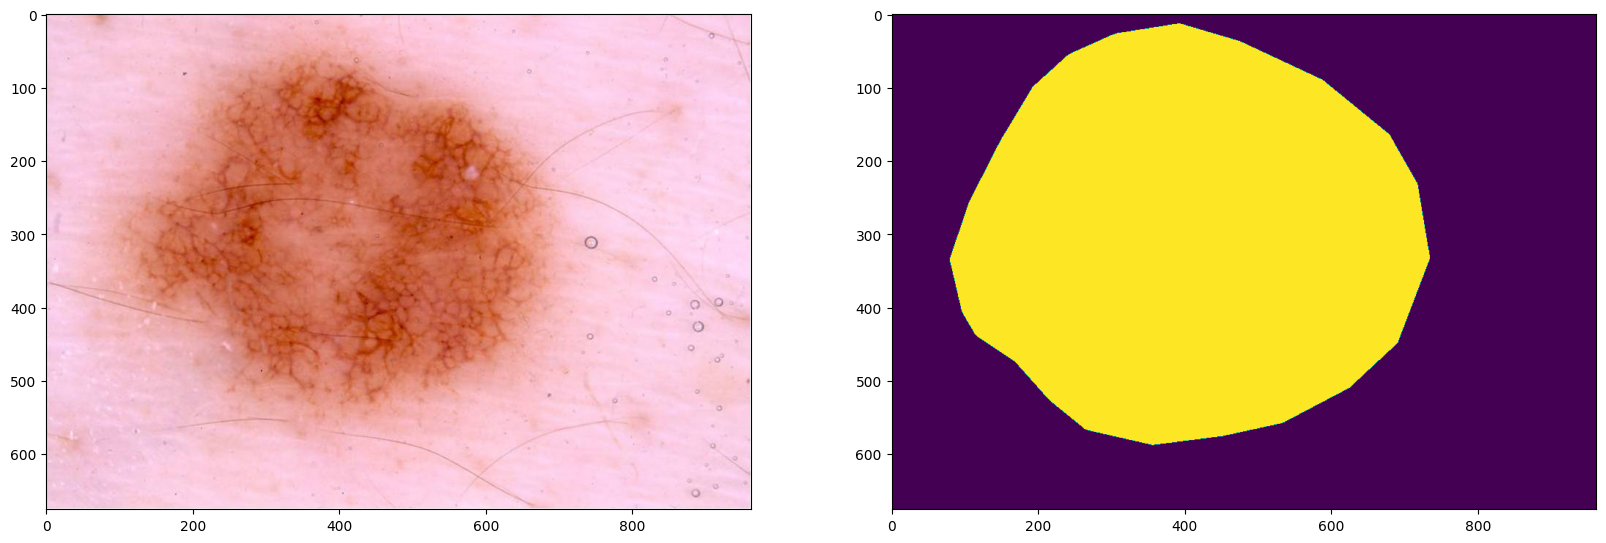

In [ ]:
image = Image.open('/content/mela_dataset/images/test/ISIC_0000234.jpg')
mask = Image.open('/content/mela_dataset/mask/test/ISIC_0000234_Segmentation.png').convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


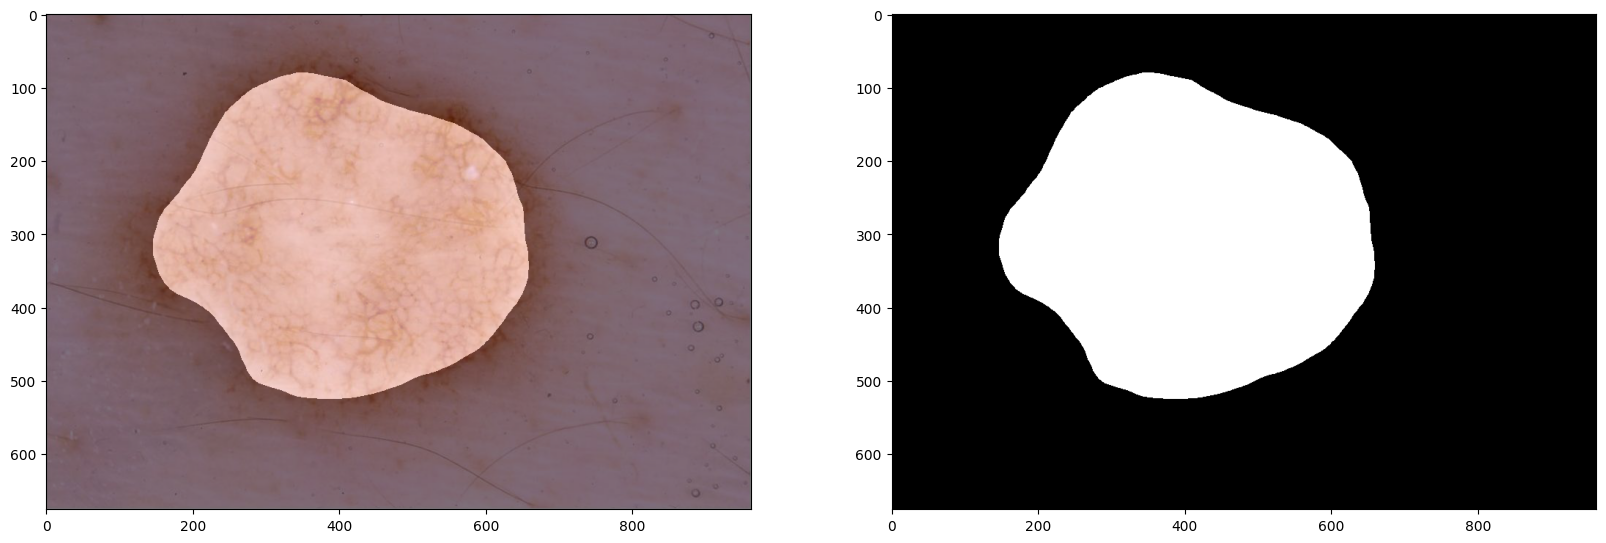

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

In [ ]:
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
import os
from tqdm import tqdm
path_imgs='/content/mela_dataset/images/test'
dest_path='/content/drive/MyDrive/tesis3/mel/'
for path in tqdm(os.listdir(path_imgs)):
    image = Image.open(path_imgs+'/'+path)
    #mask = Image.open('./data_/Test_GroundTruth/ISIC_0000253_Segmentation.png').convert('L')
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                    size=image.size[::-1], # (height, width)
                    mode='bilinear',
                    align_corners=False)

    # Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
    pp=path.split('.')[0]
    cv2.imwrite(dest_path+'pred_'+pp+'.png',color_seg)


100%|██████████| 379/379 [03:38<00:00,  1.74it/s]
